In [171]:
# Add project src to path.
import set_path

# Import modules.
import numpy as np
import time
import logging

# Visulatisation
#%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils

import open3d as o3d
from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv


from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

In [2]:
# Load data.
tilecode = '2386_9699'

# Labelled LAS file (see Notebook 0).
las_file = '../datasets/Valeriusplein/pointcloud/reduced_' + tilecode + '.laz'

# AHN data folder.
ahn_data_folder = '../datasets/Valeriusplein/ahn/'
# File with BGT building polygons.
bgt_building_file = '../datasets/Valeriusplein/bgt/bgt_buildings.csv'
# File with BGT road polygons.
bgt_road_file = '../datasets/Valeriusplein/bgt/bgt_roads.csv'
# File with <x,y> coordinates of pole-like objects.
bgt_pole_file = '../datasets/Valeriusplein/bgt/custom_poles.csv'
# File with <x,y> coordinates of street furniture objects.
bgt_street_furniture_file = '../datasets/Valeriusplein/bgt/bgt_street_furniture.csv'

# AHNReader for elevation data.
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

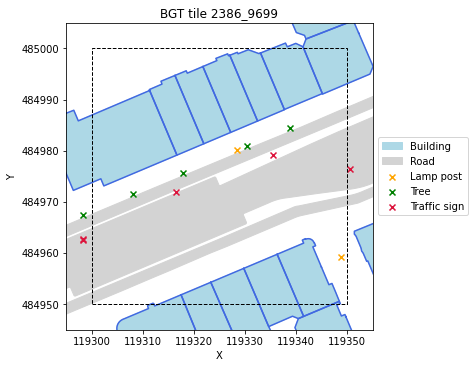

In [3]:
plot_utils.plot_bgt(tilecode, bgt_building_file, bgt_road_file, bgt_pole_file, bgt_street_furniture_file, padding=5)

### **Cable Extraction:** 2D projection

In [192]:
pointcloud = las_utils.read_las(las_file)
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = pointcloud.label

# mask for unlabelled
mask = np.where(labels == 0)[0]

In [5]:
# # Unique voxel number for each point in the point cloud
# voxelgrid.voxel_n

# # Corresponding voxel per axis for each point in the point cloud
# voxelgrid.voxel_x, voxelgrid.voxel_y, voxelgrid.voxel_z

# # non-empty 26 neighbors of voxel
# voxelgrid.get_voxel_neighbors(874)

# # voxel centers by index
# voxelgrid.voxel_centers

# # Query point coords to voxel
# voxelgrid.query(points[mask,:][:10])

# # voxel grid values?
# voxelgrid.segments

# # Binary of cell is empty or not
# voxelgrid.get_feature_vector().shape

In [6]:
# Projection Filters
def culling(grid_projection, low_threshold=0, high_threshold=4, density=False):
    '''
    An empty space around cables is assumed, therefore dense cells surrounded with
    too many further dense cells can be concluded not being part of a cable. 
    Remove points with no or 3+ 8-neighbors.
    '''
    if not grid_projection.dtype == int:
        grid_projection = grid_projection.astype(int)
        
    k = np.array([[1,1,1],[1,0,1],[1,1,1]])
    cell_density = ndimage.convolve(grid_projection, k) * grid_projection
    if density:
        return cell_density
    return np.logical_and(cell_density < high_threshold, cell_density > low_threshold).astype(int)

def closing(grid_projection, n_iterations=1):
    '''
    Removes small holes in the foreground (dilation→erosion)
    '''
    return ndimage.binary_closing(grid_projection, iterations=n_iterations)

def closing_cv(img):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

def erosion(grid_projection, n_iterations=1):
    '''
    Removes small holes in the foreground (dilation→erosion)
    '''
    return ndimage.binary_erosion(grid_projection, iterations=n_iterations)

def erode_cv(img):
    return cv.erode(img.copy(), None, iterations=1)

def canny_edge(grid_projection, sigma=0.5, low_threshold=0, high_threshold=1):
    '''
    Edge extraction algorithm (can also use openCV implementation)
    '''
    return feature.canny(grid_projection, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

def apply_filters(grid_projection, filters):
    grid = grid_projection.copy()
    for filter in filters:
        if filter == 'culling':
            grid = culling(grid)
        elif filter == 'closing':
            grid = closing(grid)
        elif filter == 'edge':
            grid = canny_edge(grid)
        elif filter == 'erosion':
            grid = erosion(grid)

    return grid

In [7]:
# 1. Voxelize
def voxelize(points, mask, voxel_size, logger=False):

    # Voxelize point cloud
    cloud = PyntCloud(pd.DataFrame(points[mask,:], columns=['x','y','z']))
    voxelgrid_id = cloud.add_structure("voxelgrid", size_x=voxel_size, size_y=voxel_size, size_z=voxel_size, regular_bounding_box=False)
    voxelgrid = cloud.structures[voxelgrid_id]
    if logger:
        print('Voxels per axis:',voxelgrid.x_y_z)
        print('Voxel size:',voxelgrid.shape)

    return voxelgrid

# 2. Top-down projection
def xy_projection(voxelgrid):
    voxelgrid_2d = voxelgrid.get_feature_vector().sum(axis=2)
    voxelgrid_2d = np.asarray(voxelgrid_2d > 0, dtype=int)
    return voxelgrid_2d

### Projection Filter Analysis

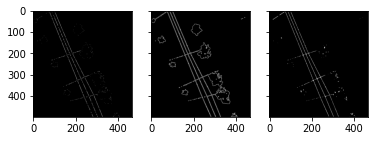

In [8]:
voxelgrid = voxelize(points, mask, 0.1)
voxelgrid_2d = xy_projection(voxelgrid)

fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(apply_filters(voxelgrid_2d, ['closing','closing','culling']), cmap='gray')
ax[1].imshow(apply_filters(voxelgrid_2d, ['closing','closing','edge']), cmap='gray')
ax[2].imshow(apply_filters(voxelgrid_2d, ['closing','edge','closing','erosion']), cmap='gray')

### Culling Analysis

If the _voxelsize_ is set too small, and the neighbouring threshold too low. Cables and object attached to cables can be recognised as high point density area and so removed.

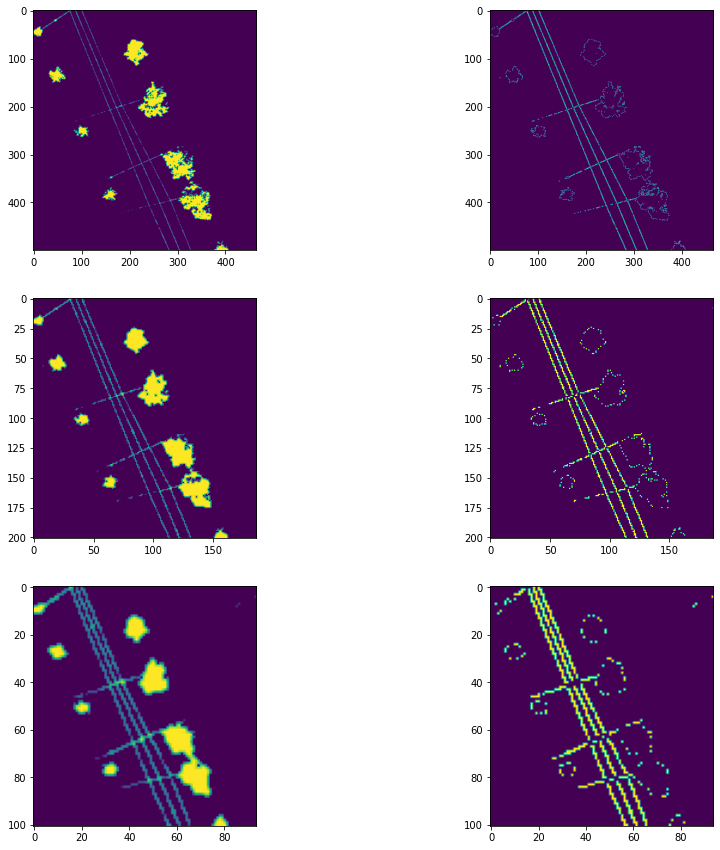

In [9]:
fig, axes = plt.subplots(3,2, figsize=(15,15))
ax = axes.ravel()

# voxel size 0.1
pc_exp = voxelize(points, mask, 0.1)
proj_exp = xy_projection(pc_exp)
proj_exp_culling_map = culling(proj_exp, density=True)
proj_exp_culled = culling(proj_exp, high_threshold=5)
ax[0].imshow(proj_exp_culling_map)
ax[1].imshow(proj_exp_culled)

# voxel size 0.25
pc_exp = voxelize(points, mask, 0.25)
proj_exp = xy_projection(pc_exp)
proj_exp_culling_map = culling(proj_exp, density=True)
proj_exp_culled = culling(proj_exp, high_threshold=5)
ax[2].imshow(proj_exp_culling_map)
ax[3].imshow(proj_exp_culled)

# voxel size 0.5
pc_exp = voxelize(points, mask, 0.5)
proj_exp = xy_projection(pc_exp)
proj_exp_culling_map = culling(proj_exp, density=True)
proj_exp_culled = culling(proj_exp, high_threshold=5)
ax[4].imshow(proj_exp_culling_map)
ax[5].imshow(proj_exp_culled)

### 3. Projection Filter

In [10]:
# OpenCV Canny implementatie
# (mu, sigma) = cv.meanStdDev(img)
# cv.Canny(proj_2d.astype('uint8'), np.double(mu - sigma), np.double(mu + sigma))

In [11]:
# 'closing' x2 --> 'edge' --> 'closing' --> 'erosion'

In [12]:
proj_2d = xy_projection(voxelize(points, mask, 0.1)).astype('uint8')
proj_2d_processed = apply_filters(proj_2d, ['closing', 'closing','edge','closing','erosion']).astype('uint8')

In [13]:
voxel_grid = voxelize(points, mask, 0.1)

### 4. Hough Transform

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(proj_2d_processed, cmap='gray')
lines = cv.HoughLines(proj_2d_processed, 1, np.pi / 180, 50)

for line in lines[:1]:
    rho = line[0][0]
    theta = line[0][1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    ax.axline((x0, y0), slope=np.tan(theta + np.pi/2))
    print(a,b,x0,y0,np.tan(theta + np.pi/2))

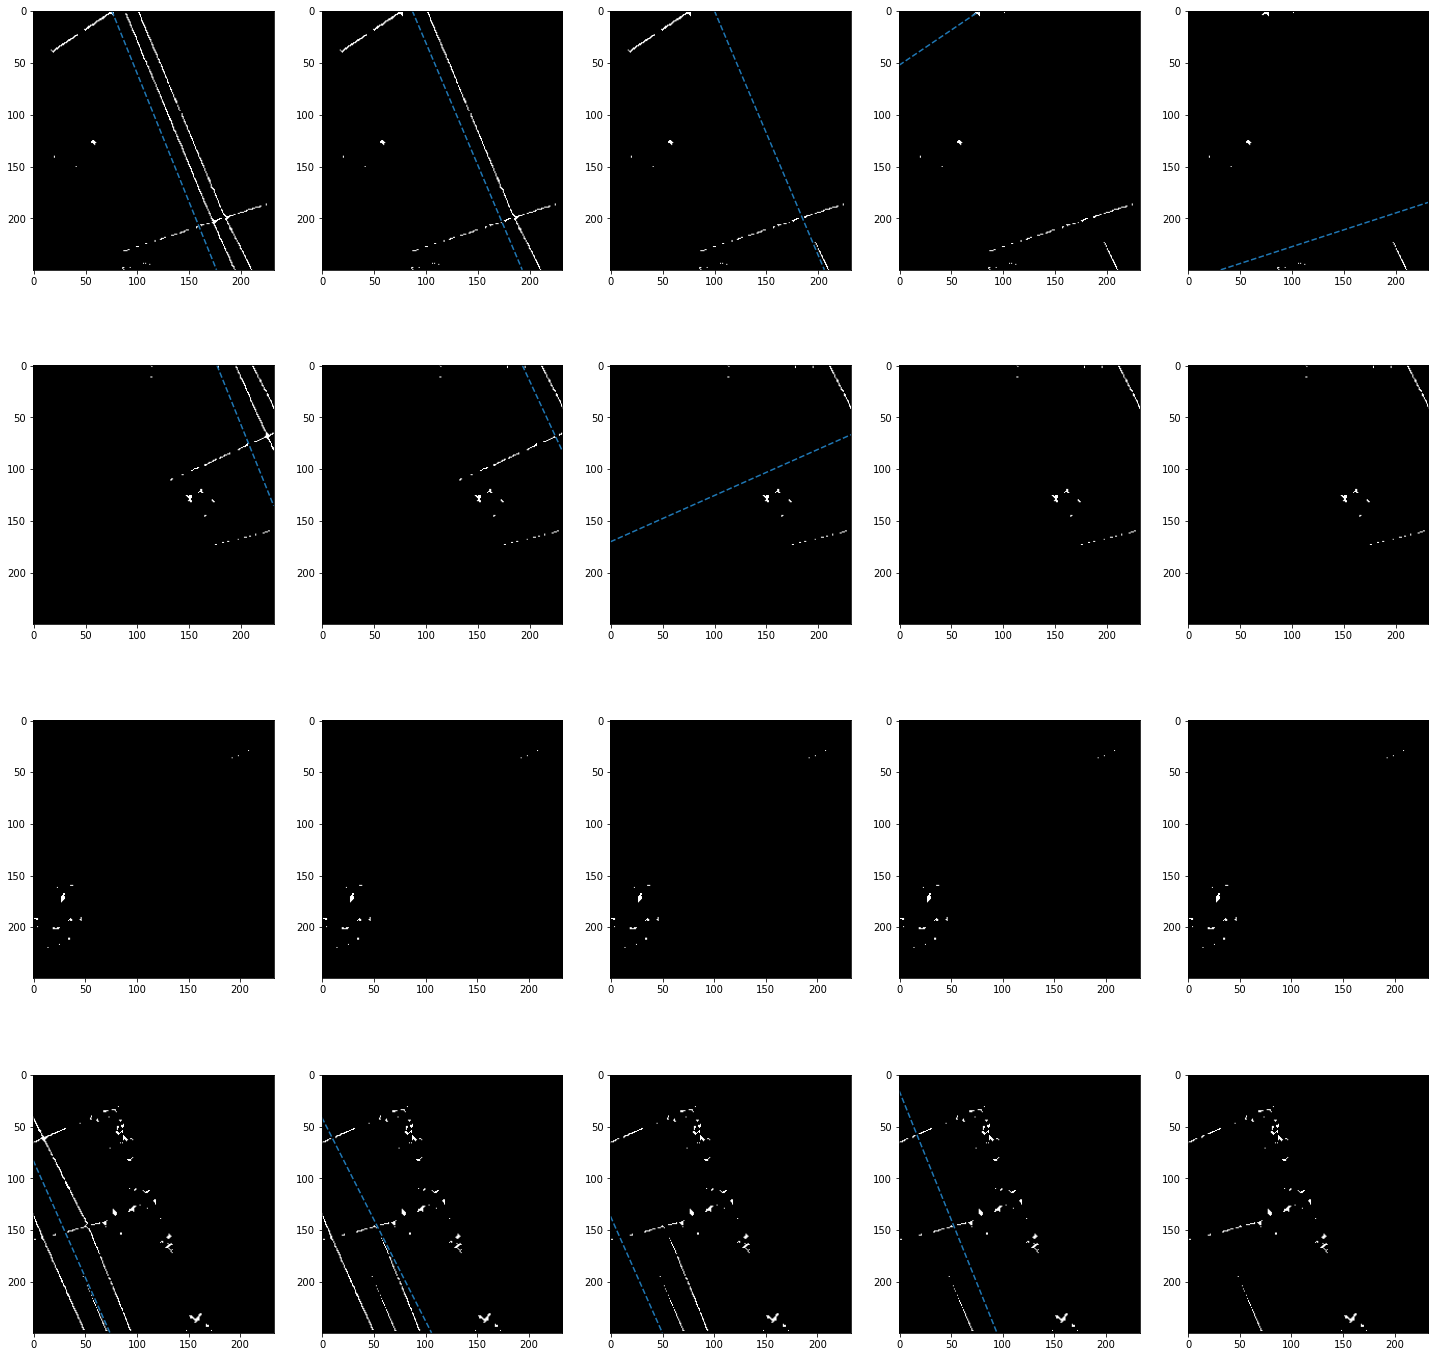

In [24]:
lines_segments = []

sections = [proj_2d_processed.copy()[:250,:232], proj_2d_processed.copy()[250:,:232], proj_2d_processed.copy()[:250,232:], proj_2d_processed.copy()[250:,232:]]

fig, axes = plt.subplots(4,5, figsize=(25,25))
ax = axes.ravel()

for s in range(4):

    proj_2d_selection = sections[s]
    n_x = proj_2d_selection.shape[1] 

    for iter in range(5):
        lines = cv.HoughLines(proj_2d_selection, 1, np.pi / 180, 40)

        if not lines is None:
            (rho, theta) = lines[0][0]
            x0 = np.cos(theta) * rho
            y0 = np.sin(theta) * rho
            slope = np.tan(theta + np.pi/2)

            x = list(range(n_x))
            y = y0 + slope * (np.arange(len(x)) - x0)
            ys = (np.round(y) - 5)[np.newaxis].T
            ys = np.hstack((ys,ys+9)).astype(int)

            for i in range(n_x):
                if not (ys[i] < 0).any():
                    proj_2d_selection[ys[i,0]:ys[i,1],i] = 0

            lines_segments.append([x, ys])

            ax[iter+s*5].axline((x0, y0), slope=slope, linestyle='--')
        ax[iter+s*5].imshow(proj_2d_selection, cmap='gray')
        ax[iter+s*5].autoscale(False)

In [75]:
voxel_points = np.vstack(np.where(voxel_grid.get_feature_vector())).T
mask = (voxel_points[:, 0:1] == 6)

In [121]:
# Shapely implementatie?
grid_shape = voxel_grid.get_feature_vector().shape
ys = lines_segments[0][1][:,0]
line_coords = np.vstack([np.vstack((np.arange(len(ys)),ys)).T for i in range(9)])
line_coords = line_coords[(line_coords[:,1] >= 0)]
mask = np.zeros((grid_shape))
mask[line_coords[:,0],line_coords[:,1],:] = 1
plane_cut = np.vstack(np.where(np.logical_and(voxel_grid.get_feature_vector(), mask))).T

In [129]:
from shapely.geometry import LineString

In [195]:
lines_segments[0][1][[76,-1],0] + 5

array([  1, 385])

In [197]:
xy1 = (voxel_grid.xyzmin[0] + 0 * voxelgrid.sizes[0], voxel_grid.xyzmin[1] + 76 * voxelgrid.sizes[1])
xy2 = (voxel_grid.xyzmin[0] + 384 * voxelgrid.sizes[0], voxel_grid.xyzmin[1] + 232 * voxelgrid.sizes[1])

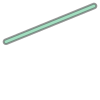

In [198]:
line = LineString([(xy1[0], xy1[1]), (xy2[0], xy2[1])])
poly = line.buffer(.5)
poly

In [199]:
clip_mask = clip_utils.poly_clip(points, poly)
labels[clip_mask] = 6
out_file = '../datasets/Valeriusplein/pointcloud/test2.laz'
las_utils.label_and_save_las(pointcloud,labels,out_file)

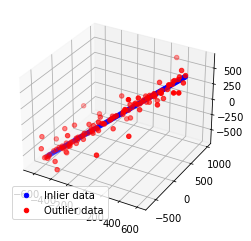

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import LineModelND, ransac

np.random.seed(seed=1)

# generate coordinates of line
point = np.array([0, 0, 0], dtype='float')
direction = np.array([1, 1, 1], dtype='float') / np.sqrt(3)
xyz = point + 10 * np.arange(-100, 100)[..., np.newaxis] * direction

# add gaussian noise to coordinates
noise = np.random.normal(size=xyz.shape)
xyz += 0.5 * noise
xyz[::2] += 20 * noise[::2]
xyz[::4] += 100 * noise[::4]

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(xyz, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
outliers = inliers == False

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[inliers][:, 0], xyz[inliers][:, 1], xyz[inliers][:, 2], c='b',
           marker='o', label='Inlier data')
ax.scatter(xyz[outliers][:, 0], xyz[outliers][:, 1], xyz[outliers][:, 2], c='r',
           marker='o', label='Outlier data')
ax.legend(loc='lower left')
plt.show()

In [22]:
xyz.shape

(200, 3)

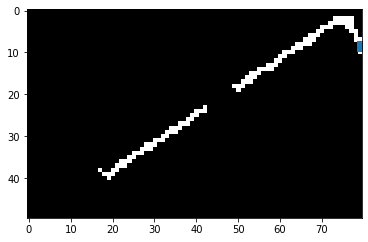

In [45]:
plt.imshow(proj_2d_processed[0:50,:80], cmap='gray')
plt.scatter([79,79],[8,9], marker='s')

(0.0, 500.0)

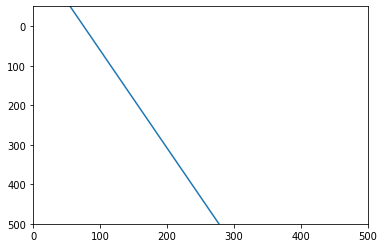

In [19]:
plt.plot(x,y)
plt.ylim(500,-50)
plt.xlim(0,500)

In [ ]:
# (x,y,x+1,y+1)

dx = x2 − x1
dy = y2 − y1

for x from range(500): 
    y = y1 + dy * (x - x1) / dx



for x from x1 to x2 do
    y = y1 + dy × (x − x1) / dx
    plot(x, y)

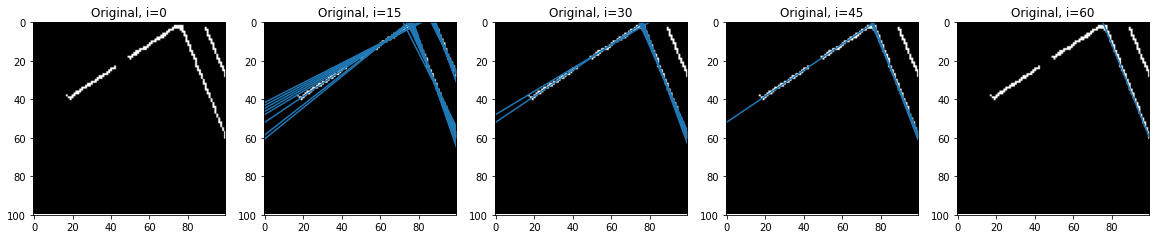

In [54]:
proj_2d_section = proj_2d_processed[:100, :100]


fig, axes = plt.subplots(1, 5, figsize=(20,10))
ax = axes.ravel()

for i in range(5):
    ax[i].imshow(proj_2d_section, cmap='gray')
    ax[i].set_title('Original, i='+str(i*15))
    if i > 0:
        lines = cv.HoughLines(proj_2d_section, 1, np.pi / 180, i*15)

        for line in lines:
            rho = line[0][0]
            theta = line[0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            ax[i].axline((x0, y0), slope=np.tan(theta + np.pi/2))
    ax[i].set_ylim((100,0))
        


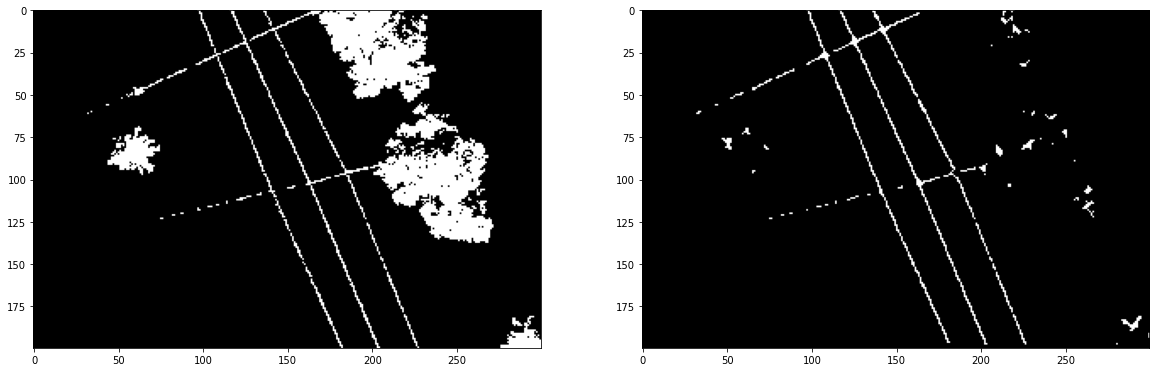

In [92]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(proj_2d[300:,100:400], cmap='gray')
ax[1].imshow(proj_2d_processed[300:,100:400], cmap='gray')
plt.show()

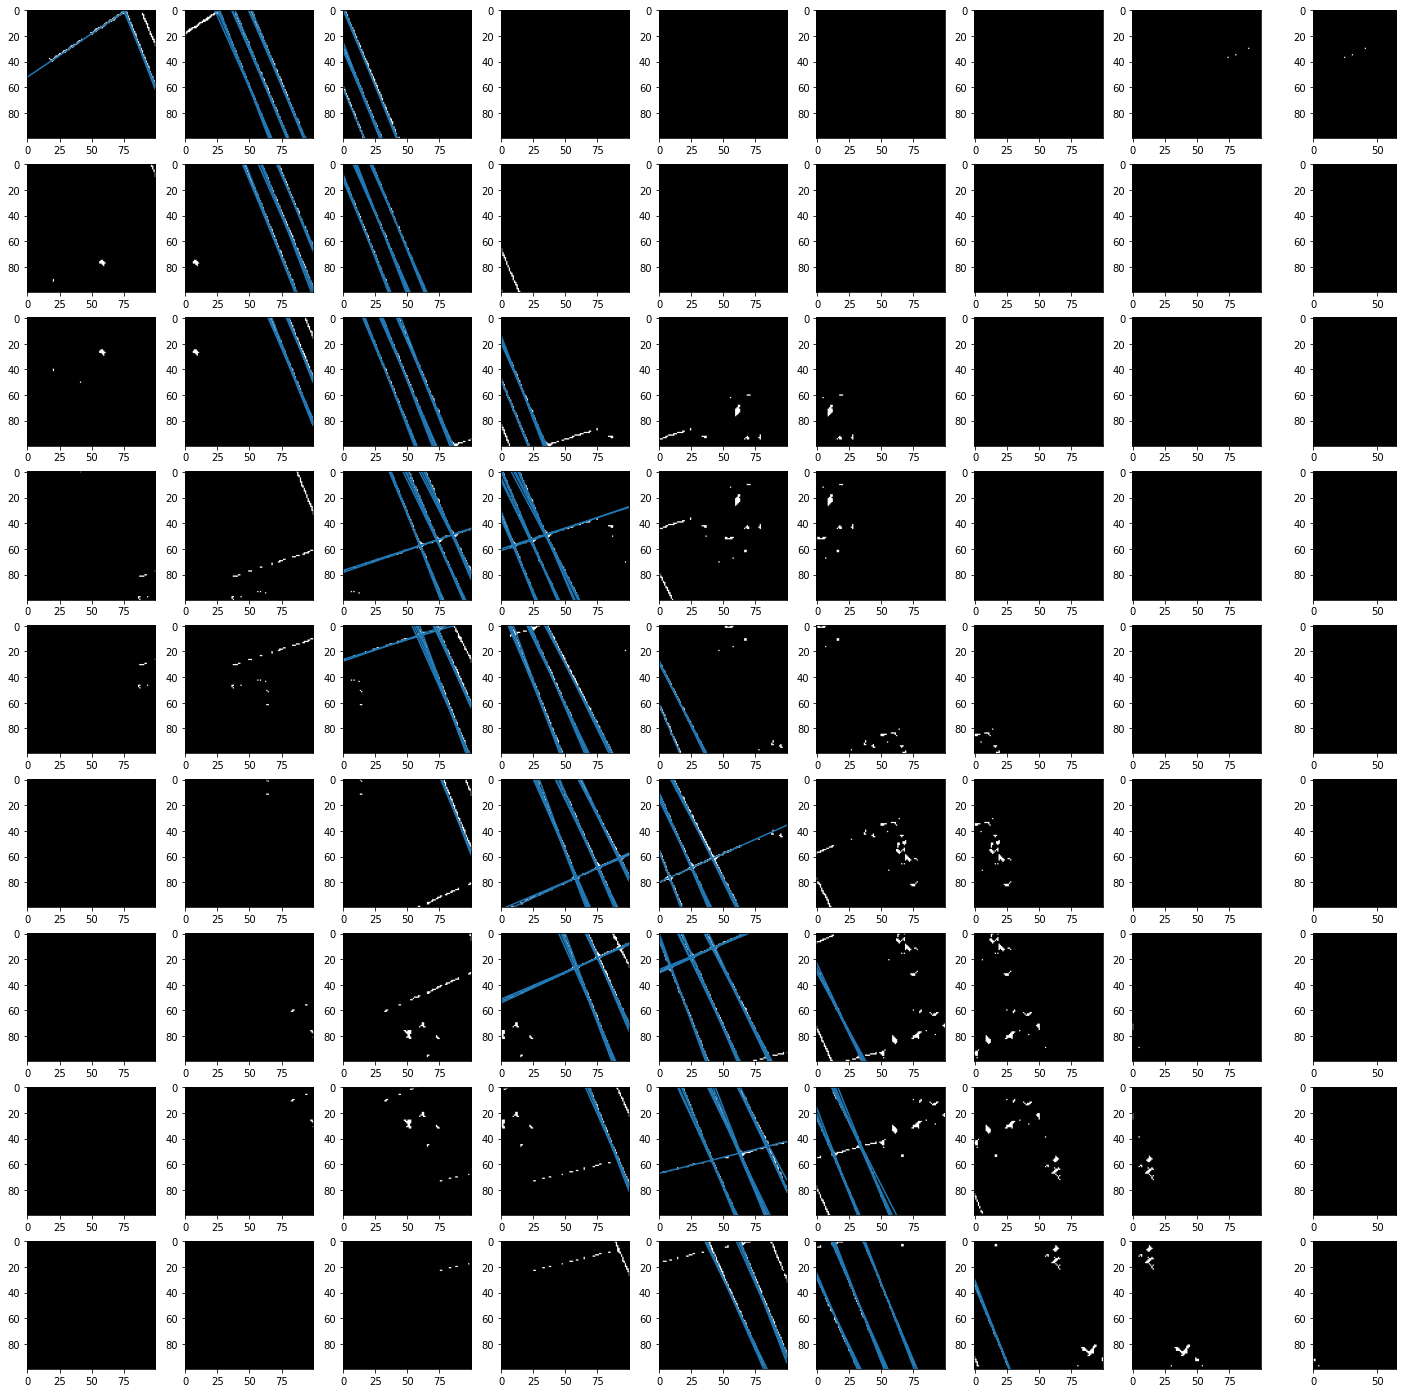

In [134]:
fig, axes = plt.subplots(9,9, figsize=(25,25))
ax = axes.ravel()
i=0
tile_lines = []
max_x, max_y = proj_2d_processed.shape
for y_lim in range(50,max_y,50):
    for x_lim in range(50,max_x,50):
        ylow = y_lim-50
        yhigh = y_lim+50
        xlow = x_lim-50
        xhigh = x_lim+50
        proj_2d_section = proj_2d_processed[ylow:yhigh,xlow:xhigh]
        lines = cv.HoughLines(proj_2d_section, 1, np.pi / 180, 35)
        ax[i].imshow(proj_2d_section, cmap='gray')

        if not lines is None:
            for line in lines:
                rho = line[0][0]
                theta = line[0][1]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                y0+50-x0 * slope
                slope = np.tan(theta + np.pi/2)
                ax[i].axline((x0, y0), slope=slope)
                tile_lines.append([(ylow,yhigh),(xlow,xhigh),y0+(-x0 * slope),slope])
                #ax[i].set_ylim((y_lim+50,y_lim-50))
                ax[i].autoscale(False)
        i+=1

In [138]:
# Merge look-a-like lines based on 10 points evaluated on the line in the tile.

for line in tile_lines[:4]:
    line[0]
    print(line[:2],'b:',line[2],'m:',line[3])

[(0, 100), (0, 100)] b: -186.86265365750776 m: 2.475085984434238
[(0, 100), (0, 100)] b: 51.867371997795416 m: -0.6745085061775815
[(0, 100), (0, 100)] b: -198.12040257501098 m: 2.6050892018824854
[(0, 100), (0, 100)] b: -176.59201475542602 m: 2.355852214589989


In [ ]:
def line_points(b,m,xlow,xhigh):
    return np.array([b + m*x for x in range(xlow,xhigh,10)])

In [114]:
all_lines

[array([[[-70.       ,   2.75762  ]],
 
        [[ 43.       ,   0.9773844]],
 
        [[-71.       ,   2.7750735]],
 
        [[-69.       ,   2.740167 ]]], dtype=float32),
 array([[[-24.       ,   2.75762  ]],
 
        [[-46.       ,   2.740167 ]],
 
        [[-34.       ,   2.740167 ]],
 
        [[-36.       ,   2.75762  ]],
 
        [[-48.       ,   2.75762  ]],
 
        [[-25.       ,   2.7750735]],
 
        [[-45.       ,   2.7227137]],
 
        [[-33.       ,   2.7227137]],
 
        [[-23.       ,   2.740167 ]],
 
        [[-21.       ,   2.7227137]]], dtype=float32),
 array([[[ 0.       ,  2.740167 ]],
 
        [[-1.       ,  2.75762  ]],
 
        [[12.       ,  2.740167 ]],
 
        [[13.       ,  2.7227137]],
 
        [[11.       ,  2.75762  ]],
 
        [[24.       ,  2.740167 ]],
 
        [[ 9.       ,  2.7750735]]], dtype=float32),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 array([[[-54.       ,   2.740167 ]],
 
        [[-55.       ,   2.75762  ]],
 


In [14]:
# 3. High-point density filter / vegation filter

# 3.1.1 Culling
# An empty space around cables is assumed, therefore dense cells surrounded with too many further dense cells can be concluded not being part of a cable. Remove points with no or 3+ 8-neighbors.


# 3.1.2 Closing (morphology)
# 


# 3.3 Canny Filter



In [19]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(voxelgrid_2d, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(voxelgrid_2d_culling, cmap='gray')
ax[1].set_title('Culling')
ax[2].imshow(voxelgrid_2d_closed, cmap='gray')
ax[2].set_title('Closing')
ax[3].imshow(voxelgrid_2d_edge, cmap='gray')
ax[3].set_title('Canny')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Canny')

In [16]:
print('points in gird:',voxelgrid_2d_culling.sum())

points in gird: 1532


In [332]:
y, x = voxelgrid_2d_culling.nonzero()
eps = 5
line_points = []
non_line_points = []
residuals = []
slope = np.tan(angle + np.pi/2)

for i in range(len(x)):
    residual = abs((y0 - y[i]) - slope * (x0 - x[i]))
    residuals.append(residual)
    if residual < eps:
        line_points.append((x[i],y[i]))
    else:
        non_line_points.append((x[i],y[i]))

len(line_points)

101

In [333]:
voxelgrid_2d_culling[np.array(line_points)[:,1], np.array(line_points)[:,0]] = 0

In [11]:
# 4. Line detection: Hough Transfrom
min_cable_length_m = 5
lines = probabilistic_hough_line(voxelgrid_2d_culling, threshold=10, line_length=int(min_cable_length_m/voxel_size), line_gap=4)

# Generating figure 2
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(voxelgrid_2d_culling, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(voxelgrid_2d_culling * 0)
for line in lines:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))


ax[1].set_xlim((0, voxelgrid_2d_culling.shape[1]))
ax[1].set_ylim((voxelgrid_2d_culling.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Probabilistic Hough')

In [397]:
fig, ax = plt.subplots(1, sharex=True, sharey=True)
ax.imshow(voxelgrid_2d_culling, cmap='gray')

p0, p1 = lines[0]
ax.plot((p0[0], p1[0]), (p0[1], p1[1]))
p0, p1 = lines[1]
ax.plot((p0[0], p1[0]), (p0[1], p1[1]))
p0, p1 = lines[2]
ax.plot((p0[0], p1[0]), (p0[1], p1[1]))

lines[0]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

((129, 225), (39, 2))

In [44]:
line_properties = []
for s in range(len(lines)):
    p0, p1 = lines[s]
    slope =  (p1[1] - p0[1]) / (p1[0]-p0[0])
    b =  p0[1] - (p0[0] * slope)
    line_properties.append((slope,b))
line_properties = np.asarray(line_properties)

In [ ]:
from itertools import combinations
i=0
for (line_a, line_b) in combinations(list(range(len(lines))), 2):
    slope_diff, b_diff = abs(line_properties[line_a] - line_properties[line_b])
    if slope_diff < 0.1 and b_diff < 3:
        print((line_a, line_b), slope_diff, b_diff)
        i += 1
        fig, ax = plt.subplots(1, sharex=True, sharey=True)
        ax.imshow(voxelgrid_2d_culling, cmap='gray')

        p0, p1 = lines[line_a]
        ax.plot((p0[0], p1[0]), (p0[1], p1[1]))
        p0, p1 = lines[line_b]
        ax.plot((p0[0], p1[0]), (p0[1], p1[1]))

In [385]:

eps = 5

line_points = {}
for s in range(len(lines)):
    line_points[s] = []
line_points['unlabelled'] = []

y, x = voxelgrid_2d_culling.nonzero()
for i in range(len(x)):
    for s in range(len(lines)):
        p0, p1 = lines[s]
        dist_line = np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

        dist_A = np.sqrt((p0[0] - x[i])**2 + (p0[1] - y[i])**2)
        dist_B = np.sqrt((p1[0] - x[i])**2 + (p1[1] - y[i])**2)

        if abs(dist_line - (dist_A + dist_B)) < eps:
            line_points[s].append((x[i],y[i]))
            break

    line_points['unlabelled'].append((x[i],y[i]))



In [ ]:
# 5. Cable extraction: 3D-RANSAC

